# Basic characterizations of UA Q3
### using Experiment and Analysis classes

In [1]:
from qm.qua import *
from qm.QuantumMachinesManager import QuantumMachinesManager
from qm import SimulationConfig, LoopbackInterface
from qm.octave import *
from qm.octave.octave_manager import ClockMode
from configuration import *
from scipy import signal
from qm import SimulationConfig
from qualang_tools.bakery import baking
from qualang_tools.units import unit
from qm import generate_qua_script
from qm.octave import QmOctaveConfig
from set_octave import ElementsSettings, octave_settings
from quam import QuAM
from scipy.io import savemat
from scipy.io import loadmat
from scipy.optimize import curve_fit
from scipy.signal import savgol_filter
from qutip import *
from typing import Union
from macros import *
import datetime 
import os
import time
import warnings
import json
import matplotlib.pyplot as plt
import numpy as np
import Labber

from ExperimentClass import ExperimentHandle
from AnalysisClass import AnalysisHandle

warnings.filterwarnings("ignore")

qubit_index = 2 # for UA Q3
res_index = 2 # for UA Q3
flux_index = 2 # for UA Q3
TLS_index = 0 # for TLS of interest

2023-12-16 19:35:06,078 - qm - INFO     - Starting session: c494b724-2160-4ee6-990b-c10a25aeba77


In [2]:
machine._save("quam_state.json")

In [3]:
Experiment = ExperimentHandle()
Analysis = AnalysisHandle()
machine = Analysis.get_machine()

In [4]:
# initialize Labber-controlled hardware
Experiment.set_Labber(Analysis.get_machine(), qubit_index, res_index, flux_index)
# set octave to external clock
#Experiment.set_external_clock()

In [5]:
machine.qubits[qubit_index].lo = machine.qubits[qubit_index].f_01 + 50e6
machine = Analysis.set_machine(machine)

In [ ]:
# this updates the octave settings, including rf_gain and rf_output_mode
Experiment.octave_calibration(qubit_index,res_index,flux_index,calibration_flag = False)

In [ ]:
# octave calibration
Experiment.octave_calibration(qubit_index,res_index,flux_index,calibration_flag = True)

## resonator switch calibration

### switch delay

In [ ]:
# reduce the resonator freq, so sig is stronger
machine.resonators[res_index].f_readout -= 2E6
machine._save("quam_state.json")

In [ ]:
%matplotlib inline
rr_switch_delay_sweep = np.arange(70,110,1)
machine, rr_switch_delay_sweep, sig_amp = Experiment.exp1D.RR.rr_switch_delay(rr_switch_delay_sweep, qubit_index, res_index, flux_index, 
                          n_avg = 160E3, cd_time = 20E3, simulate_flag = False, simulation_len = 500, plot_flag = True)

### switch buffer

In [ ]:
%matplotlib inline
rr_switch_buffer_sweep = np.arange(0,25 + 1,1)
machine, rr_switch_delay_sweep, sig_amp = Experiment.exp1D.RR.rr_switch_buffer(rr_switch_buffer_sweep, qubit_index, res_index, flux_index, 
                          n_avg = 20E3, cd_time = 20E3, simulate_flag = False, simulation_len = 500, plot_flag = True)

## Time of flight

In [ ]:
# time_of_flight
# experiment
machine, adc1, adc2, adc1_single, adc2_single = Experiment.exp1D.RR.time_of_flight(qubit_index,res_index,flux_index, n_avg = 5E3, cd_time = 10E3, simulate_flag = False, simulation_len = 1000)
# plot
%matplotlib inline
dc_offset_i, dc_offset_q, delay = Analysis.exp1D.time_of_flight(adc1,adc2,adc1_single,adc2_single)

In [ ]:
# update the offset
machine.global_parameters.con1_downconversion_offset_I += 0.000928
machine.global_parameters.con1_downconversion_offset_Q += 0.00124
#machine.global_parameters.time_of_flight = 304-0
machine = Analysis.set_machine(machine)

## 1D RO resonator spectroscopy

In [ ]:
%matplotlib inline
machine = Analysis.get_machine()
res_freq_sweep = machine.resonators[res_index].f_readout + np.arange(-10E6,10E6 + 1.0,0.05E6)
machine, res_freq_sweep, sig_amp = Experiment.exp1D.RR.rr_freq(res_freq_sweep, qubit_index, res_index, flux_index, 
                           n_avg = 1E3, cd_time = 5E3, readout_state = 'g', simulate_flag = False, simulation_len = 1000)

In [ ]:
# find the minimal
%matplotlib inline
res_freq = Analysis.exp1D.rr_freq(res_freq_sweep, sig_amp)
machine.resonators[res_index].f_readout = res_freq.tolist() + 0E6
machine = Analysis.set_machine(machine)

## 2D RO resonator spectroscopy vs DC flux

In [ ]:
res_freq_sweep = machine.resonators[res_index].f_readout + np.arange(-6e6, 7e6, 0.1E6)
dc_flux_sweep = np.arange(-9,9.001,0.15)
%matplotlib qt
machine, res_freq_sweep, dc_flux_sweep, sig_amp = Experiment.exp2D.RR.rr_vs_dc_flux(res_freq_sweep, dc_flux_sweep, qubit_index, res_index, flux_index, 
                                plot_flag = False, n_avg = 4E3, cd_time = 10E3)

In [ ]:
%matplotlib inline
ham_param = Analysis.exp2D.rr_vs_dc_flux(res_freq_sweep, dc_flux_sweep, sig_amp, init_guess = None)
poly_param = Analysis.exp2D.qubit_vs_dc_flux_guess(ham_param)

In [ ]:
# save the fitting parameters
machine.resonators[res_index].tuning_curve = ham_param.tolist()
machine.qubits[qubit_index].DC_tuning_curve = poly_param.tolist()
machine = Analysis.set_machine(machine)

In [ ]:
# save the sweep spot flux according to fitted parameter
machine.flux_lines[flux_index].max_frequency_point = Analysis.get_sweept_spot(machine.qubits[qubit_index].DC_tuning_curve)
machine = Analysis.set_machine(machine)

## 1D qubit spectroscopy @ sweep spot

In [ ]:
# set to sweet spot
machine = Experiment.set_QDAC(qubit_index,res_index,flux_index,machine.flux_lines[flux_index].max_frequency_point)

In [ ]:
# calibrate RO
%matplotlib qt
#res_freq_sweep = np.arange(7.2575E9,7.2675E9 + 1.0,0.03E6)
ham_param = machine.resonators[res_index].tuning_curve
res_freq_est = Analysis.exp2D.ham([machine.flux_lines[flux_index].max_frequency_point], ham_param[0], ham_param[1], ham_param[2], ham_param[3], ham_param[4], ham_param[5], output_flag = 1) * 1E6 # to Hz
res_freq_sweep = int(res_freq_est[0]) + np.arange(-5E6, 5E6 + 1, 0.05E6)
machine, res_freq_sweep, sig_amp = Experiment.exp1D.RR.rr_freq(res_freq_sweep, qubit_index, res_index, flux_index, 
                       n_avg = 5E3, cd_time = 20E3, plot_flag = False, simulate_flag = False, simulation_len = 1000)
%matplotlib inline
res_freq = Analysis.exp1D.rr_freq(res_freq_sweep, sig_amp)
res_freq = int(res_freq.tolist())
machine.resonators[res_index].f_readout = res_freq + 0E6
machine.resonators[res_index].lo = res_freq + 50E6
machine = Analysis.set_machine(machine)

In [ ]:
# calibrate octave
Experiment.octave_calibration(qubit_index,res_index,flux_index)

In [ ]:
# for the DC flux
qubit_freq_est = np.polyval(machine.qubits[qubit_index].DC_tuning_curve,machine.flux_lines[flux_index].max_frequency_point) * 1E6 # in Hz
# for the fast flux
#qubit_freq_est = np.polyval(machine.qubits[qubit_index].AC_tuning_curve,0.0) * 1E6 # in Hz
machine.qubits[qubit_index].lo = int(qubit_freq_est.tolist()) + 50E6
qubit_freq_sweep = int(qubit_freq_est) + np.arange(-100E6, 100E6 + 1, 2E6)
    
%matplotlib qt
machine, qubit_freq_sweep, sig_amp = Experiment.exp1D.Rabi.qubit_freq(qubit_freq_sweep, qubit_index, res_index, flux_index, 
                                      pi_amp_rel = 1.0, ff_amp = 0.0, n_avg = 1E3, cd_time = 20E3, plot_flag = False, 
                                      simulate_flag = False, simulation_len = 4000)

In [ ]:
%matplotlib inline
qubit_freq = Analysis.exp1D.peak_fit(x=qubit_freq_sweep,y=sig_amp,method="gaussian")
qubit_freq = int(qubit_freq.tolist())
machine.qubits[qubit_index].f_01 = qubit_freq + 0E6
machine.qubits[qubit_index].lo = qubit_freq + 50E6
machine = Analysis.set_machine(machine)

In [ ]:
# calibrate octave
Experiment.octave_calibration(qubit_index,res_index,flux_index,machine=machine,calibration_flag = True)

In [ ]:
machine.qubits[qubit_index].f_tls[0] = machine.qubits[qubit_index].f_01 + 0E6
machine = Analysis.set_machine(machine)

## Rabi

### time rabi

In [ ]:
%matplotlib qt
rabi_duration_sweep = np.arange(4, 40 + 0.1, 1)  # in units of clock cyles
rabi_duration_sweep = rabi_duration_sweep.astype(int)
machine, rabi_duration_sweep, sig_amp = Experiment.exp1D.Rabi.rabi_length(rabi_duration_sweep, qubit_index, res_index, flux_index, 
          pi_amp_rel = 1.0, n_avg = 2E3, cd_time = 20E3, plot_flag = False, machine = machine, simulate_flag = False, simulation_len = 10_000)

In [ ]:
%matplotlib inline
pi_pulse_length = Analysis.exp1D.rabi_length(rabi_duration_sweep,sig_amp,plot_flag = True)

In [ ]:
machine.qubits[qubit_index].pi_length[0] = 40
machine = Analysis.set_machine(machine)

### power rabi

In [ ]:
%matplotlib qt
rabi_amp_sweep_rel = np.arange(0.3, 2.0, 0.05) 
machine, rabi_amp_sweep_abs, sig_amp = Experiment.exp1D.Rabi.rabi_amp(rabi_amp_sweep_rel, qubit_index, res_index, flux_index, 
                                          n_avg = 10E3, cd_time = 20E3, plot_flag = False, machine = machine)

In [ ]:
%matplotlib inline
pi_pulse_amp = Analysis.exp1D.rabi_length(rabi_amp_sweep_abs,sig_amp,method = "power_rabi", plot_flag = True)

In [ ]:
machine.qubits[qubit_index].pi_amp[0] = pi_pulse_amp.tolist()
machine = Analysis.set_machine(machine)

## calibrate qubit XY line switch

### switch delay

In [ ]:
%matplotlib inline
qubit_switch_delay_sweep = np.arange(70,110,1)
for i in range(4):
    machine, qubit_switch_delay_sweep, sig_amp = Experiment.exp1D.Rabi.qubit_switch_delay(qubit_switch_delay_sweep, qubit_index, res_index, flux_index, 
                              n_avg = 160E3, cd_time = 20E3, simulate_flag = False, simulation_len = 500, plot_flag = False)

### switch buffer

In [ ]:
%matplotlib inline
qubit_switch_buffer_sweep = np.arange(0,70 + 1,2)
for k in range(5):
    machine, qubit_switch_buffer_sweep, sig_amp = Experiment.exp1D.Rabi.qubit_switch_buffer(qubit_switch_buffer_sweep, qubit_index, res_index, flux_index, 
                              n_avg = 20E3, cd_time = 20E3, simulate_flag = False, simulation_len = 500, plot_flag = True)

## T1

In [ ]:
%matplotlib qt
tau_sweep_abs = np.arange(100,30E3+1,400)
machine, tau_sweep_abs, sig_amp = Experiment.exp1D.T1.qubit_T1(tau_sweep_abs, qubit_index, res_index, flux_index, 
                   n_avg = 5E3, cd_time = 80E3, simulate_flag = False, simulation_len = 15_000, plot_flag = False)

In [ ]:
%matplotlib inline
q1_T1 = Analysis.exp1D.T1(tau_sweep_abs,sig_amp,method = "exp")
machine.qubits[qubit_index].T1 = int(q1_T1.tolist())
machine = Analysis.set_machine(machine)

## Ramsey

## ef transition

### ef frequency

In [ ]:
%matplotlib qt
ef_freq_sweep = machine.qubits[qubit_index].f_01 + np.arange(-180E6, -100E6 + 1, 0.5E6) 
machine, ef_freq_sweep, sig_amp = Experiment.exp1D.Rabi.ef_freq(ef_freq_sweep, qubit_index, res_index, flux_index, 
                      pi_amp_rel = 1, pi_amp_rel_ef = 1.0, n_avg = 2E3, cd_time = 20E3, readout_state = 'g', plot_flag = False, 
                      simulate_flag = False, simulation_len = 4000)

In [ ]:
%matplotlib inline
ef_freq = Analysis.exp1D.peak_fit(x=ef_freq_sweep,y=sig_amp,method="gaussian")

In [ ]:
machine.qubits[qubit_index].anharmonicity = machine.qubits[qubit_index].f_01 - int(ef_freq)
machine = Analysis.set_machine(machine)

### ef transition time Rabi

In [ ]:
%matplotlib qt
rabi_duration_sweep = np.arange(4, 80 + 0.1, 1)  # in units of clock cyles
rabi_duration_sweep = rabi_duration_sweep.astype(int)
machine, rabi_duration_sweep, sig_amp = Experiment.exp1D.Rabi.ef_rabi_length(rabi_duration_sweep, qubit_index, res_index, flux_index, 
          pi_amp_rel = 1.0, pi_amp_rel_ef = 1.0,  n_avg = 2E3, cd_time = 20E3, readout_state = 'g', plot_flag = False, machine = machine, simulate_flag = False, simulation_len = 10_000)

In [ ]:
%matplotlib inline
pi_pulse_length = Analysis.exp1D.rabi_length(rabi_duration_sweep,sig_amp,plot_flag = True)

In [ ]:
machine.qubits[qubit_index].pi_length[1] = 64
machine = Analysis.set_machine(machine)

### ef transition power Rabi

In [ ]:
%matplotlib qt
rabi_amp_sweep_rel = np.arange(0.2, 2.0, 0.05) 
machine, rabi_amp_sweep_abs, sig_amp = Experiment.exp1D.Rabi.ef_rabi_amp(rabi_amp_sweep_rel, qubit_index, res_index, flux_index, 
                          pi_amp_rel = 1.0, n_avg = 10E3, cd_time = 20E3, readout_state = 'g', plot_flag = False, machine = machine,
                          simulate_flag = False, simulation_len = 1000)

In [ ]:
%matplotlib inline
pi_pulse_amp = Analysis.exp1D.rabi_length(rabi_amp_sweep_abs,sig_amp,method = "power_rabi", plot_flag = True)

In [ ]:
machine.qubits[qubit_index].pi_amp[1] = pi_pulse_amp
machine = Analysis.set_machine(machine)

## residual |e> state population

### |e> readout calibration

In [ ]:
# calibrate RO
%matplotlib qt
#res_freq_sweep = np.arange(7.2575E9,7.2675E9 + 1.0,0.03E6)
ham_param = machine.resonators[res_index].tuning_curve
res_freq_est = Analysis.exp2D.ham([flux_index,machine.flux_lines[flux_index].max_frequency_point], ham_param[0], ham_param[1], ham_param[2], ham_param[3], ham_param[4], ham_param[5], output_flag = 1) * 1E6 # to Hz
res_freq_sweep = int(res_freq_est[0]) + np.arange(-5E6, 5E6 + 1, 0.05E6)
machine, res_freq_sweep, sig_amp = Experiment.exp1D.RR.rr_freq(res_freq_sweep, qubit_index, res_index, flux_index, 
                       n_avg = 10E3, cd_time = 20E3, plot_flag = False, readout_state = 'e', simulate_flag = False, simulation_len = 1000)
%matplotlib inline
res_freq = Analysis.exp1D.rr_freq(res_freq_sweep, sig_amp)
res_freq = int(res_freq.tolist())
machine.resonators[res_index].f_readout = res_freq + 0E6
machine.resonators[res_index].lo = res_freq + 50E6
machine = Analysis.set_machine(machine)

In [ ]:
# calibrate octave
Experiment.octave_calibration(qubit_index,res_index,flux_index,machine=machine)

### A_ref

In [ ]:
%matplotlib qt
#rabi_duration_sweep = np.arange(4, 80 + 0.1, 2)  # in units of clock cyles
rabi_duration_sweep = np.array([80/4, 160/4])  
rabi_duration_sweep = rabi_duration_sweep.astype(int)
machine, rabi_duration_sweep, sig_amp = Experiment.exp1D.Rabi.ef_rabi_length(rabi_duration_sweep, qubit_index, res_index, flux_index, 
          pi_amp_rel = 1.0, pi_amp_rel_ef = 1.0,  n_avg = 1E7, cd_time = 20E3, readout_state = 'e', plot_flag = False, machine = machine, simulate_flag = False, simulation_len = 10_000)

### A_sig

In [ ]:
%matplotlib qt
#rabi_duration_sweep = np.arange(4, 80 + 0.1, 2)  # in units of clock cyles
rabi_duration_sweep = np.array([80/4, 160/4])  
rabi_duration_sweep = rabi_duration_sweep.astype(int)
machine, rabi_duration_sweep_thermal, sig_amp_thermal = Experiment.exp1D.Rabi.ef_rabi_length_thermal(rabi_duration_sweep, qubit_index, res_index, flux_index, 
          pi_amp_rel = 1.0, pi_amp_rel_ef = 0.0,  n_avg = 1E7, cd_time = 20E3, readout_state = 'e', plot_flag = False, machine = machine, 
          simulate_flag = False, simulation_len = 10_000)

## 2D qubit spectroscopy vs dc flux

In [ ]:
# try the experiment
%matplotlib inline
dc_flux_sweep = machine.flux_lines[flux_index].max_frequency_point + np.arange(-0.55,0.55+1E-4,0.05)
_,qubit_freq_sweep,dc_flux_sweep,sig_amp_qubit = Experiment.exp2D.Rabi.qubit_freq_vs_dc_flux(dc_flux_sweep,qubit_index,res_index,flux_index,
                                 n_avg = 5E3, cd_time = 18E3, pi_amp_rel = 1.0, plot_flag = True)

In [ ]:
# udpate the sweet spot
%matplotlib inline
poly_param = Analysis.exp2D.qubit_vs_dc_flux(qubit_freq_sweep, dc_flux_sweep, sig_amp_qubit, fit_order = 2, plot_flag = False)
machine.flux_lines[flux_index].max_frequency_point = Analysis.get_sweept_spot(poly_param).tolist() + 0E1
print(f"sweet spot flux: {machine.flux_lines[flux_index].max_frequency_point:.5f} V")

In [ ]:
# save the sweep spot flux according to fitted parameter
poly_param = Analysis.exp2D.qubit_vs_dc_flux(qubit_freq_sweep, dc_flux_sweep, sig_amp_qubit, fit_order = 4, plot_flag = True)
machine.qubits[qubit_index].DC_tuning_curve = poly_param.tolist()
machine = Analysis.set_machine(machine)
Analysis.update_analysis_tuning_curve(qubit_index,res_index,flux_index)

## 2D qubit spectroscopy vs fast flux

In [6]:
# set DC voltage to sweet spot, after possible dc flux sweep
machine = Experiment.set_QDAC(qubit_index,res_index,flux_index,machine.flux_lines[flux_index].max_frequency_point)
machine = Analysis.set_machine(machine)

### slow version, to find the initial fast flux tuning curve

2023-12-16 19:41:09,274 - qm - INFO     - Performing health check


INFO:qm.api.frontend_api:Performing health check


2023-12-16 19:41:09,285 - qm - INFO     - Health check passed


INFO:qm.api.frontend_api:Health check passed


------------------------------------- Calibrates q2 for (LO, IF) = (5.791 GHz, 290.000 MHz)
2023-12-16 19:41:13,651 - qm - INFO     - Compiling program


INFO:qm.QuantumMachine:Compiling program


2023-12-16 19:41:47,372 - qm - INFO     - Performing health check.4% (n=5/7) --> elapsed time: 38.08s


INFO:qm.api.frontend_api:Performing health check


2023-12-16 19:41:47,384 - qm - INFO     - Health check passed


INFO:qm.api.frontend_api:Health check passed


------------------------------------- Calibrates q2 for (LO, IF) = (5.532 GHz, 290.000 MHz)
2023-12-16 19:41:52,716 - qm - INFO     - Compiling program


INFO:qm.QuantumMachine:Compiling program


Progress: [##################################################] 100.0% (n=7/7) --> elapsed time: 68.42s
2023-12-16 19:42:17,695 - qm - INFO     - Performing health check


INFO:qm.api.frontend_api:Performing health check


2023-12-16 19:42:17,706 - qm - INFO     - Health check passed


INFO:qm.api.frontend_api:Health check passed


------------------------------------- Calibrates q2 for (LO, IF) = (5.206 GHz, 290.000 MHz)
2023-12-16 19:42:22,578 - qm - INFO     - Compiling program


INFO:qm.QuantumMachine:Compiling program


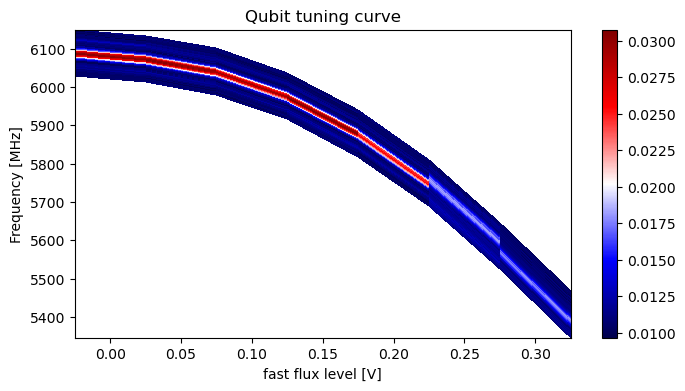

In [11]:
# try the experiment
%matplotlib inline
#ff_sweep = np.arange(-0.02,-0.28-1E-4,-0.02)
ff_sweep = np.arange(0,0.3+1E-4,0.05)
qubit_if_sweep = np.arange(-60E6, 60E6 + 1, 1E6)
machine,qubit_freq_sweep,ff_sweep_abs,sig_amp_qubit = Experiment.exp2D.Rabi.qubit_freq_vs_fast_flux_slow(ff_sweep,qubit_if_sweep,
          qubit_index,res_index,flux_index,ff_to_dc_ratio = None, machine = machine, n_avg = 1E3, cd_time = 20E3, pi_amp_rel = 1.0, plot_flag = True)

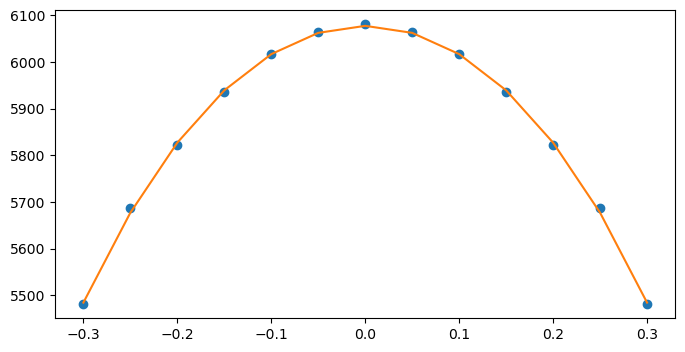

In [12]:
# save the fitted tuning curve
%matplotlib inline
poly_param = Analysis.exp2D.qubit_vs_fast_flux(qubit_freq_sweep, ff_sweep_abs, sig_amp_qubit, fit_order = 4, plot_flag = True)
machine.qubits[qubit_index].AC_tuning_curve = poly_param.tolist()
machine = Analysis.set_machine(machine)
Analysis.update_analysis_tuning_curve(qubit_index,res_index,flux_index)

### fast version, runs blockwise 2D sweeps

In [13]:
%matplotlib inline
q_freq_max = np.floor(np.polyval(machine.qubits[qubit_index].tuning_curve, 0.0) * 1E6)
qubit_freq_sweep = np.arange(q_freq_max, 4.0E9, -4E6)
#qubit_freq_sweep = np.arange(5.55E9,4.0E9,-4E6)
qubit_if_sweep = np.arange(-60E6, 60E6 + 1, 0.5E6)
machine,qubit_freq_sweep,ff_sweep_abs,sig_amp_qubit = Experiment.exp2D.Rabi.qubit_freq_vs_fast_flux(qubit_freq_sweep,qubit_if_sweep,
          qubit_index,res_index,flux_index, n_avg = 2E3, cd_time = 20E3, pi_amp_rel = 1.0, plot_flag = False)

AttributeError: 'Qubit' object has no attribute 'tuning_curve'

In [ ]:
# save the fitted tuning curve
%matplotlib inline
poly_param = Analysis.exp2D.qubit_vs_fast_flux(qubit_freq_sweep, ff_sweep_abs, sig_amp_qubit, fit_order = 4, plot_flag = True)
machine.qubits[qubit_index].tuning_curve = poly_param.tolist()
machine = Analysis.set_machine(machine)
Analysis.update_analysis_tuning_curve(qubit_index,res_index,flux_index)

# TLS experiments

## TLS SWAP spectroscopy

In [ ]:
machine = Analysis.get_machine()
Experiment.octave_calibration(qubit_index,res_index,flux_index,calibration_flag = True, machine = machine)

### coarse, no baking

In [ ]:
%matplotlib qt
tau_sweep_abs = np.arange(16,200,4)
ff_sweep_abs = np.arange(0.33,0.35,0.001)
machine, ff_sweep_abs, tau_sweep_abs, sig_amp = Experiment.exp2D.SWAP.swap_coarse(tau_sweep_abs, ff_sweep_abs, qubit_index, res_index, flux_index, 
                      n_avg = 4E3, cd_time = 20E3, simulate_flag=False, simulation_len=10_000, plot_flag=True, machine = machine)

### fine, with baking

In [ ]:
%matplotlib qt
tau_sweep_abs = np.arange(4,80,1)
ff_sweep_abs = np.arange(0.425,0.44,0.001)
machine, ff_sweep_abs, tau_sweep_abs, sig_amp = Experiment.exp2D.SWAP.swap_fine(tau_sweep_abs, ff_sweep_abs, qubit_index, res_index, flux_index, 
                      n_avg = 4E3, cd_time = 20E3, simulate_flag=False, simulation_len=10_000, plot_flag=True, machine = machine)

In [ ]:
machine.flux_lines[flux_index].iswap.length.append(25)
machine.flux_lines[flux_index].iswap.level.append(0.434)
machine = Analysis.set_machine(machine)

## TLS T1

In [ ]:
TLS_index = 1

In [ ]:
%matplotlib qt
tau_sweep_abs = np.arange(200,800E3+1,20E3)
machine, tau_sweep_abs, sig_amp = Experiment.exp1D.T1.TLS_T1(tau_sweep_abs, qubit_index, res_index, flux_index, TLS_index,
                   n_avg = 2E3, cd_time = 1000E3, simulate_flag = False, simulation_len = 15_000, plot_flag = True)

In [ ]:
%matplotlib inline
tls_T1 = Analysis.exp1D.T1(tau_sweep_abs,sig_amp,method = "exp")

## TLS drive

### TLS spectroscopy

In [ ]:
# TLS freq estimate based on SWAP flux amplitude
TLS_freq_est = np.polyval(machine.qubits[qubit_index].tuning_curve,machine.flux_lines[flux_index].iswap.level)
TLS_freq_est = np.round(TLS_freq_est[0] * 1E6)
machine.qubits[qubit_index].f_tls[TLS_index+1] = (int(TLS_freq_est.tolist()))
machine.qubits[qubit_index].lo = int(TLS_freq_est.tolist()) - 200E6

In [ ]:
# save the current qubit to the f_tls[0]
machine.qubits[qubit_index].f_tls[0] = machine.qubits[qubit_index].f_01
# set the "qubit frequency"
machine.qubits[qubit_index].f_01 = machine.qubits[qubit_index].f_tls[TLS_index+1]

In [ ]:
# calibrate octave for TLS sweep
Experiment.octave_calibration(qubit_index,res_index,flux_index,machine = machine,calibration_flag = True)

In [ ]:
%matplotlib qt
TLS_freq_sweep = TLS_freq_est + np.arange(-70E6,70E6+1,1.0E6)
machine, TLS_freq_sweep, sig_amp = Experiment.exp1D.Rabi.TLS_freq(TLS_freq_sweep, qubit_index, res_index, flux_index, TLS_index,
                  pi_amp_rel = 1.0, n_avg = 2E3, cd_time_qubit = 20E3, cd_time_TLS = 20E3, simulate_flag = False, simulation_len = 10_000, plot_flag = True, machine = machine)

In [ ]:
%matplotlib inline
qubit_freq = Analysis.exp1D.peak_fit(x=TLS_freq_sweep,y=sig_amp,method="gaussian")
qubit_freq = int(qubit_freq.tolist())
machine.qubits[qubit_index].f_tls[TLS_index+1] = qubit_freq + 0E6
machine.qubits[qubit_index].lo = qubit_freq - 200E6
machine = Analysis.set_machine(machine)

### TLS rabi

In [ ]:
# save the current qubit to the f_tls[0]
machine.qubits[qubit_index].f_tls[0] = machine.qubits[qubit_index].f_01
# set the "qubit frequency"
machine.qubits[qubit_index].f_01 = machine.qubits[qubit_index].f_tls[TLS_index+1]

In [ ]:
%matplotlib qt
rabi_duration_sweep = np.arange(4, 300 + 0.1, 4)  # in units of clock cyles
machine, rabi_duration_sweep, sig_amp = Experiment.exp1D.Rabi.TLS_rabi_length(rabi_duration_sweep, qubit_index, res_index, flux_index, TLS_index,
                  pi_amp_rel = 1.0, n_avg = 10E3, cd_time_qubit = 20E3, cd_time_TLS = 20E3, simulate_flag = False, simulation_len = 10_000, plot_flag = True, machine = machine)

## TLS drive debug

### 1D SWAP

In [ ]:
%matplotlib qt
tau_sweep_abs = np.arange(16,300,4)
machine, tau_sweep_abs, sig_amp = Experiment.exp1D.SWAP.swap_coarse(tau_sweep_abs, qubit_index, res_index, flux_index, TLS_index, 
                n_avg = 4E3, cd_time = 20E3, simulate_flag=False, simulation_len=1000, plot_flag=True, machine = machine)

### qubit Rabi-SWAP

In [ ]:
%matplotlib qt
rabi_duration_sweep = np.arange(4, 80 + 0.1, 2)  # in units of clock cyles
rabi_duration_sweep = rabi_duration_sweep.astype(int)
machine, rabi_duration_sweep, sig_amp = Experiment.exp1D.SWAP.rabi_SWAP(rabi_duration_sweep, qubit_index, res_index, flux_index, TLS_index,  
          pi_amp_rel = 1.0, n_avg = 4E3, cd_time = 20E3, plot_flag = True, machine = machine, simulate_flag = False, simulation_len = 10_000)

### SWAP-Rabi

In [ ]:
%matplotlib qt
rabi_duration_sweep = np.arange(4, 80 + 0.1, 2)  # in units of clock cyles
rabi_duration_sweep = rabi_duration_sweep.astype(int)
machine, rabi_duration_sweep, sig_amp = Experiment.exp1D.SWAP.SWAP_rabi(rabi_duration_sweep, qubit_index, res_index, flux_index, TLS_index,  
          pi_amp_rel = 1.0, n_avg = 4E3, cd_time = 20E3, plot_flag = True, machine = machine, simulate_flag = False, simulation_len = 10_000)

### Rabi-SWAP-SWAP

In [ ]:
%matplotlib qt
rabi_duration_sweep = np.arange(4, 80 + 0.1, 2)  # in units of clock cyles
rabi_duration_sweep = rabi_duration_sweep.astype(int)
machine, rabi_duration_sweep, sig_amp = Experiment.exp1D.SWAP.rabi_SWAP2(rabi_duration_sweep, qubit_index, res_index, flux_index, TLS_index,  
          pi_amp_rel = 1.0, n_avg = 4E3, cd_time = 10E3, plot_flag = True, machine = machine, simulate_flag = False, simulation_len = 10_000)